<a href="https://colab.research.google.com/github/kimgayoung0728/CAS2105-Mini-AI-Project/blob/main/2024149067_GayoungKim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device being used: cuda
Total samples: 294
                              text  label  note
0      이번 시험에서 1등을 못 하면 난 완전 실패자야.      0  흑백논리
1            내 편이 아니면 너는 내 적일 뿐이야.      0  흑백논리
2  프로젝트가 완벽하지 않으면 아예 제출 안 하는 게 나아.      0  흑백논리
3       그 사람은 나를 전혀 사랑하지 않는 게 분명해.      0  흑백논리
4         한 번이라도 실수하면 그건 전문가가 아니야.      0  흑백논리
Train Set: 235 samples, Test Set: 59 samples

[Baseline] Accuracy: 0.6102

[AI Model] Starting training process...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Map:   0%|          | 0/59 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.827012,0.711864
2,No log,0.617119,0.779661
3,No log,0.556566,0.830508



[AI Model] Accuracy: 0.8305


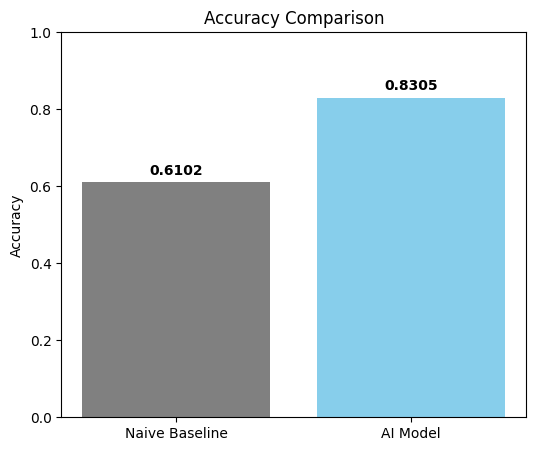


--- [Analysis] Improvement Cases (AI Correct vs Baseline Wrong) ---
Text: 회식도 업무의 연장이야, 빠지는 건 직무 유기지
True Label: Should Statements
Baseline Prediction: All-or-Nothing (Incorrect)
AI Model Prediction: Should Statements (Correct)
--------------------------------------------------
Text: 고객이 컴플레인 걸었어, 이제 본사에 소문나고 난 해고 1순위야
True Label: Catastrophizing
Baseline Prediction: Should Statements (Incorrect)
AI Model Prediction: Catastrophizing (Correct)
--------------------------------------------------
Text: 주가 1% 떨어졌네 내 노후 자금 다 날아가고 난 결국 폐지 주우러 다니겠지
True Label: Catastrophizing
Baseline Prediction: All-or-Nothing (Incorrect)
AI Model Prediction: Catastrophizing (Correct)
--------------------------------------------------


In [7]:
# Cognitive Distortion Classification
# 2024149067 Gayoung Kim

# -----------------------------------------------------------------------------
# 1. Setup and Installation
# -----------------------------------------------------------------------------
# Install required libraries
!pip install -q transformers datasets accelerate scikit-learn pandas matplotlib

import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Set random seed for reproducibility (Guideline 7: Reproducibility)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")

# -----------------------------------------------------------------------------
# 2. Dataset Preparation
# -----------------------------------------------------------------------------
# Load dataset
if not os.path.exists("data.csv"):
    print("Error: 'data.csv' not found. Please upload the dataset.")
else:
    df = pd.read_csv("data.csv")

    # Preprocess column names (remove spaces & convert to lower case to prevent errors)
    df.columns = df.columns.str.strip().str.lower()

    # Verify data loading
    print(f"Total samples: {len(df)}")
    print(df.head())

    # Label Mapping
    label_map = {0: "All-or-Nothing", 1: "Catastrophizing", 2: "Should Statements"}

    # Split data into Train (80%) and Test (20%) - Stratified split
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    print(f"Train Set: {len(train_df)} samples, Test Set: {len(test_df)} samples")

# -----------------------------------------------------------------------------
# 3. Naive Baseline
# -----------------------------------------------------------------------------
class NaiveKeywordClassifier:
    """
    A simple rule-based classifier that counts keywords for each distortion type.
    """
    def __init__(self):
        # Define keywords (Korean) for each class
        self.keywords = {
            0: ["전부", "모두", "아니면", "완벽", "망했", "실패", "1등", "최고", "쓰레기", "적", "배신", "없어"],
            1: ["죽을", "큰일", "끔찍", "심장", "망할", "파산", "끝장", "어떡하지", "무서워", "불안", "영원히"],
            2: ["해야", "당연", "의무", "도리", "상식", "예의", "기본", "무조건", "절대", "감히"]
        }

    def predict(self, text):
        text = str(text)
        counts = {0: 0, 1: 0, 2: 0}

        # Count occurrences of keywords
        for label, words in self.keywords.items():
            for word in words:
                if word in text:
                    counts[label] += 1

        # Select the label with the highest count
        max_count = max(counts.values())

        # Random guess if no keywords are found (Naive fallback)
        if max_count == 0:
            return random.choice([0, 1, 2])

        # Handle ties by random selection
        candidates = [k for k, v in counts.items() if v == max_count]
        return random.choice(candidates)

# Evaluate Baseline
baseline_model = NaiveKeywordClassifier()
baseline_preds = [baseline_model.predict(t) for t in test_df['text']]
baseline_acc = accuracy_score(test_df['label'], baseline_preds)

print(f"\n[Baseline] Accuracy: {baseline_acc:.4f}")

# -----------------------------------------------------------------------------
# 4. AI Pipeline
# -----------------------------------------------------------------------------
print("\n[AI Model] Starting training process...")

# Convert pandas DataFrames to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df[['text', 'label']])
test_ds = Dataset.from_pandas(test_df[['text', 'label']])

# Load Pre-trained Model & Tokenizer (klue/bert-base)
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.to(device)

# Tokenization function
def tokenize_data(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_train = train_ds.map(tokenize_data, batched=True)
tokenized_test = test_ds.map(tokenize_data, batched=True)

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # 3 epochs is sufficient for small data
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",           # Evaluate at the end of each epoch
    learning_rate=2e-5,
    save_strategy="no",              # Do not save checkpoints to save space
    report_to="none"                 # Disable external logging
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

# Train the model
trainer.train()

# Make predictions
preds = trainer.predict(tokenized_test)
ai_preds = np.argmax(preds.predictions, axis=1)
ai_acc = accuracy_score(test_df['label'], ai_preds)

print(f"\n[AI Model] Accuracy: {ai_acc:.4f}")

# -----------------------------------------------------------------------------
# 5. Evaluation and Visualization
# -----------------------------------------------------------------------------
# 1) Visualize Accuracy Comparison
plt.figure(figsize=(6, 5))
plt.bar(['Naive Baseline', 'AI Model'], [baseline_acc, ai_acc], color=['gray', 'skyblue'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

# Add text labels on bars
for i, v in enumerate([baseline_acc, ai_acc]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# 2) Qualitative Analysis (Cases where AI succeeded but Baseline failed)
print("\n--- [Analysis] Improvement Cases (AI Correct vs Baseline Wrong) ---")
count = 0
for i in range(len(test_df)):
    true_label = test_df.iloc[i]['label']
    base_p = baseline_preds[i]
    ai_p = ai_preds[i]

    # Check for cases where Baseline failed and AI succeeded
    if base_p != true_label and ai_p == true_label:
        print(f"Text: {test_df.iloc[i]['text']}")
        print(f"True Label: {label_map[true_label]}")
        print(f"Baseline Prediction: {label_map[base_p]} (Incorrect)")
        print(f"AI Model Prediction: {label_map[ai_p]} (Correct)")
        print("-" * 50)

        count += 1
        if count >= 3: break # Show only top 3 examples